In [ ]:
import tensorflow as tf
import os #for file management
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
base_dir = r'/content/drive/MyDrive/Final Train Data/Fruit1' #  dataset directory

In [ ]:
# Set up the data generators with more aggressive data augmentation

IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,

    # data augmentation
    # rotation_range=40,
    # width_shift_range=0.3,
    # height_shift_range=0.3,
    shear_range=30,
    zoom_range=0.3,
    # horizontal_flip=True,
    # vertical_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training'
)

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation'
)

IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3) 

base_model = tf.keras.applications.MobileNetV2(
    input_shape= IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

for layer in base_model.layers:
    layer.trainable = False
    
# Build the model with additional layers and a different output activation function
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)


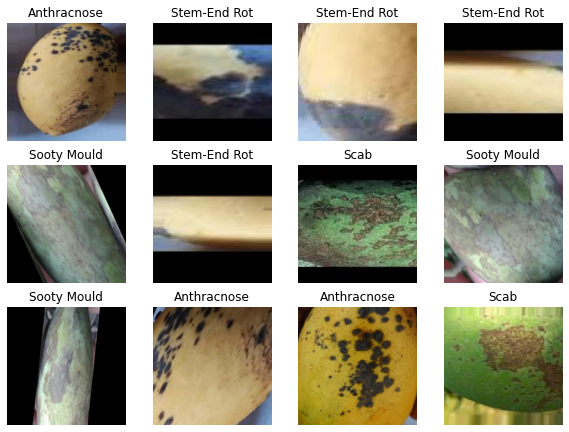

In [ ]:
# get the first batch of images
x_batch, y_batch = next(train_generator)

# get the class names from the generator
class_names = list(train_generator.class_indices.keys())

# plot the first 9 images in the batch
plt.figure(figsize=(10, 10))
for i in range(12):
    # get the true class of the image
    true_class = class_names[y_batch[i].argmax()]

    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(x_batch[i])
    plt.title(true_class)
    plt.axis("off")
plt.show()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 64)          737344    
                                                                 
 batch_normalization (BatchN  (None, 5, 5, 64)         256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2, 2, 64)          0         
                                                        

In [ ]:
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        print(layer.kernel_size)

NameError: ignored

In [ ]:
#Next we have to create a labels.txt file that will hold all our labels (important for Flutter)
print(train_generator.class_indices) #prints every single key and class of that dataset
labels = '\n'.join(sorted(train_generator.class_indices.keys())) #print all these keys as a list of labels into a text file called labels.txt
with open('fruit_tuned_model.txt', 'w') as f: #writes to the labels.txt file, and if it doesnt exists, it creates one, and if it does exist, it will overrite it. (thats what 'w' is for)
    f.write(labels)

#preprocessing of raw data is hence complete and now its time to build our neural network

{'Anthracnose': 0, 'Scab': 1, 'Sooty Mould': 2, 'Stem-End Rot': 3}


In [ ]:
epochs = 10 #higher the epochs, more accurate is the NN, however it could cause Overfitting, if too high
history = model.fit(
    train_generator, 
    epochs = epochs, 
    validation_data=val_generator
)

Epoch 1/10
10/10 [==============================] - 219s 22s/step - loss: 0.7240 - accuracy: 0.7406 - precision: 0.7840 - recall: 0.7094 - val_loss: 0.5379 - val_accuracy: 0.8411 - val_precision: 0.8523 - val_recall: 0.8411
Epoch 2/10
10/10 [==============================] - 36s 4s/step - loss: 0.1633 - accuracy: 0.9507 - precision: 0.9567 - recall: 0.9425 - val_loss: 0.4193 - val_accuracy: 0.8675 - val_precision: 0.8675 - val_recall: 0.8675
Epoch 3/10
10/10 [==============================] - 34s 3s/step - loss: 0.0910 - accuracy: 0.9770 - precision: 0.9770 - recall: 0.9770 - val_loss: 0.3192 - val_accuracy: 0.9073 - val_precision: 0.9073 - val_recall: 0.9073
Epoch 4/10
10/10 [==============================] - 34s 3s/step - loss: 0.0497 - accuracy: 0.9852 - precision: 0.9885 - recall: 0.9852 - val_loss: 0.2812 - val_accuracy: 0.9205 - val_precision: 0.9205 - val_recall: 0.9205
Epoch 5/10
10/10 [==============================] - 34s 3s/step - loss: 0.0399 - accuracy: 0.9869 - precision:

In [ ]:
#now that we have our neural network trained with tensorflow and keras, we can export it 
saved_model_dir = '' #means current directory
tf.saved_model.save(model, saved_model_dir) #saves to the current directory

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) 
tflite_model = converter.convert() #converts our model into a .tflite model which flutter uses for ondevice machine learning

with open('fruit_tuned_model.tflite', 'wb') as f: #to write the converted model into a file, written as binary so add 'wb' instead of 'w'
  f.write(tflite_model)

In [ ]:
#use below codes to download files locally if using google colab
from google.colab import files
files.download('fruit_tuned_model.tflite')
files.download('fruit_tuned_model.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Analyzing the Result

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']
print(acc)
print(val_acc)
print(loss)
print(val_loss)
print(precision)
print(val_precision)
print(recall)
print(val_recall )

[0.7405582666397095, 0.9507389068603516, 0.977011501789093, 0.9852216839790344, 0.9868637323379517, 0.9901477694511414, 1.0, 0.9983579516410828, 1.0, 0.9967159032821655]
[0.8410596251487732, 0.8675496578216553, 0.9072847962379456, 0.9205297827720642, 0.9470198750495911, 0.9602649211883545, 0.9735099077224731, 0.9801324605941772, 0.9801324605941772, 0.9933775067329407]
[0.7240438461303711, 0.1633409708738327, 0.09100422263145447, 0.04967234283685684, 0.03987441584467888, 0.030065467581152916, 0.012909763492643833, 0.01166112907230854, 0.006160410586744547, 0.015696797519922256]
[0.5378797650337219, 0.41932663321495056, 0.31916895508766174, 0.2812020182609558, 0.17372757196426392, 0.09516828507184982, 0.08781891316175461, 0.025778857991099358, 0.030513623729348183, 0.03313864395022392]
[0.7840290665626526, 0.9566666483879089, 0.977011501789093, 0.9884678721427917, 0.9868637323379517, 0.9901477694511414, 1.0, 1.0, 1.0, 0.9967159032821655]
[0.8523489832878113, 0.8675496578216553, 0.9072847

In [ ]:
final_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_precision = history.history['precision'][-1]
final_val_precision = history.history['val_precision'][-1]
final_recall = history.history['recall'][-1]
final_val_recall = history.history['val_recall'][-1]
print(final_acc)
print(final_val_acc)
print(final_loss)
print(final_val_loss)
print(final_precision)
print(final_val_precision)
print(final_recall)
print(final_val_recall)

0.9967159032821655
0.9933775067329407
0.015696797519922256
0.03313864395022392
0.9967159032821655
0.9933775067329407
0.9967159032821655
0.9933775067329407
